# U.S. County Mental Health Analysis

This Jupyter Notebook is the result of the collaborative work between Song Ying and Mate Pocs, carried out for Flatiron School's Mod4 Project. 

In [12]:
# importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import seaborn as sns

# importing our code we created for the project
import us_county

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Data Preparation

There are two available data files for this project: 
<br>
- 2019 County Health Rankings Data - v2.xls
- analytic_data2019.csv
<br>

The <code>.xls</code> file contains some of the raw data, aggregated statistics calculated from the data, and most importantly, the data dictionary. The <code>.csv</code> file contains more raw data. After comparing the two files, we decided to use the <code>.xls</code> file for getting a better understanding with the data dictionary, and use the <code>.csv</code> file to import the data. 

In [13]:
# importing data from .csv file
df = pd.read_csv('analytic_data2019.csv')

The <code>.csv</code> file has a few columns that identify the county, and then, different aspects of the same variable. We decided that a good way to filter down to the necessary data is to search for "rawvalue"-s. These usually correspond to the bold figures in the Excel file. For a couple of categories, multiple columns are bold in the <code>.xls</code> file, but in those cases, we decided that we can still use the <code>rawvalue</code> columns, the other bold value is the simple the reciprocal of the first one in these cases. 

In [14]:
# keeping first 6 columns and rawvalues
columns_to_drop = []
for column in df.columns[6:]:
    if not (df[column][0]).endswith('rawvalue'):
        columns_to_drop.append(column)
        
df.drop(columns_to_drop, inplace = True, axis = 1)

In [15]:
# dropping first row, which is the second header
df.drop(0, axis = 0, inplace = True)

Next we are dropping the aggregate rows. The per country / per state aggregate rows are coded either as '000' or 0 in the <code>Country FIPS Code</code> column. 

In [16]:
df.shape

(3194, 111)

In [17]:
df = df[df['County FIPS Code'] != '000']

In [18]:
df = df[df['County FIPS Code'] != 0]

In [19]:
df.shape

(3142, 111)

We dropped 52 rows, which sounds correct.
<br>

We are left with 3,142 rows. From the [Wikipedia] page: _"As of 2018, there are currently 3,142 counties and county-equivalents in the 50 states and the District of Columbia."_

[Wikipedia]: https://en.wikipedia.org/wiki/County_(United_States)

Next, we are checking for missing data. There are a lot of columns with over 1,000 missing elements. Interestingly, there are items at the end of the <code>.csv</code> file that are only populated for one state. We are looping through the columns, and dropping the columns where more than 10% of the rows are missing. 

In [20]:
# dropping columns missing more than 10% of the data
columns_to_drop = []
for column in df.columns:
    if df[column].isna().sum() > len(df) / 10:
        columns_to_drop.append(column)
        
df.drop(columns_to_drop, axis = 1, inplace = True)

In [21]:
# TODO print columns to drop and length

In [22]:
# checking for remaining missing data
df_missing_values = pd.DataFrame()

missing_number = []
column_name = []

for column in df.columns:
    column_name.append(column)
    missing_number.append(df[column].isna().sum())
    
df_missing_values['column_name'] = column_name
df_missing_values['missing_number'] = missing_number

In [23]:
df_missing_values = df_missing_values.sort_values('missing_number', ascending = False)

In [24]:
df_missing_values.head(10)

,column_name,missing_number
23,Mental health providers raw value,252
34,Violent crime raw value,191
18,Sexually transmitted infections raw value,158
19,Teen births raw value,144
21,Primary care physicians raw value,135
53,Children eligible for free or reduced price lu...,121
10,Low birthweight raw value,107
35,Injury deaths raw value,103
27,High school graduation raw value,99
22,Dentists raw value,85


There are smaller portions missing from multiple columns. We did not want to exclude these from the analysis, or delete rows where any element was missing. We decided to impute these values with a median method. Before we do that, however, we need to make sure that the values are floats, and we are also renaming the columns to make it easier to worki with them. 

In [25]:
rename_dictionary = us_county.rename_dictionary
df.rename(columns=rename_dictionary, inplace = True);

All columns should be floats. 

In [26]:
for column in df.columns[6:]:
    df[column] = df[column].map(lambda x: float(x))

Next, we create a separate DataFrame with the median values. 

In [27]:
state_median_df = df.groupby('state').median()

In [28]:
state_median_df.head()

,YPLL,poor_health,poor_physical_health_days,poor_mental_health_days,LBW,smokers,obese,food_environment_index,physically_inactive,exercise_acces,...,above_age65,nonhisp_africanamerican,americanindian_alaskannative,asian,nativehawaiian_otherpacific,hispanic,nonhispanic_whit,notproficient_english,females,rural
state,,,,,,,,,,,,,,,,,,,,,
AK,7876.536065,0.154541,3.745194,3.442669,0.058552,0.187008,0.3220,6.90,0.211,0.786260,...,0.125880,0.009324,0.163031,0.024990,0.003460,0.049265,0.498513,0.009650,0.472936,0.793375
AL,10875.865439,0.222160,4.699272,4.740404,0.101167,0.207356,0.3710,7.10,0.309,0.483473,...,0.184502,0.230050,0.005291,0.005651,0.000738,0.026710,0.689275,0.005943,0.514528,0.712322
AR,10744.462101,0.226897,4.893776,4.968565,0.084203,0.207739,0.3580,6.60,0.345,0.532240,...,0.190218,0.081519,0.007149,0.005667,0.000569,0.035295,0.796092,0.005745,0.507171,0.650608
AZ,7833.688943,0.208533,4.509992,4.033836,0.070935,0.156047,0.2970,6.20,0.243,0.666617,...,0.183112,0.012587,0.043069,0.011259,0.001833,0.300955,0.541257,0.038441,0.499798,0.331972
CA,6435.574344,0.163038,3.685637,3.820639,0.064516,0.123397,0.2445,7.85,0.182,0.870061,...,0.153316,0.018185,0.024039,0.044984,0.003119,0.256328,0.518193,0.065316,0.501381,0.160382


In [29]:
overall_median_df = df.median()

In [30]:
overall_median_df.head()

FIPS_state        29.000000
FIPS_county       79.000000
FIPS_full      29176.000000
year            2019.000000
YPLL            8130.554003
dtype: float64

In [32]:
def impute_per_state_median(row, column):
    "Returns the median value of the column, based on state value in row"
    if math.isnan(row[column]):
        current_state = row['state']
        current_state_median = state_median_df.loc[current_state][column]
        overall_median = overall_median_df[column]
        if math.isnan(current_state_median):
            return overall_median
        else:
            return current_state_median
    else:
        return row[column]

In [33]:
# code runs for some time, if you want to follow, uncomment print(column) line
for column in df.columns[6:]:
#     print(column)
    df[column] = df.apply(lambda x: impute_per_state_median(x, column), axis = 1)

As a final step in the data preparation, we are saving the clean data as a .csv file so we can just import it in the future. 

In [37]:
df.to_csv('data_cleaned.csv', index = False)

## Variable Initial Exploration

In this section, we are using visual aids to explore the data, check if the dependent variable is a good choice, etc. 

In [4]:
df = pd.read_csv('data_cleaned.csv')

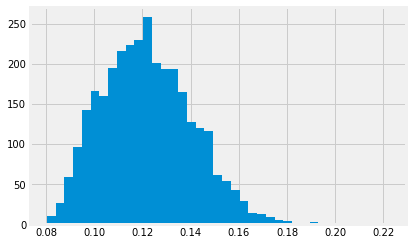

In [5]:
plt.hist(df['frequent_mental_distress'], bins = 'auto')
plt.show()

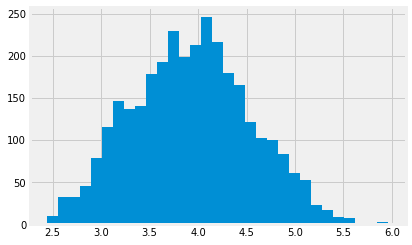

In [6]:
plt.hist(df['poor_mental_health_days'], bins = 'auto')
plt.show()

The two variables look similar and seem to be highly correlated. The question is, do we want to analyse the overall mental health (poor_mental_health_days), or the percentage of extremely poor mental health in population (frequent_mental_distress). 

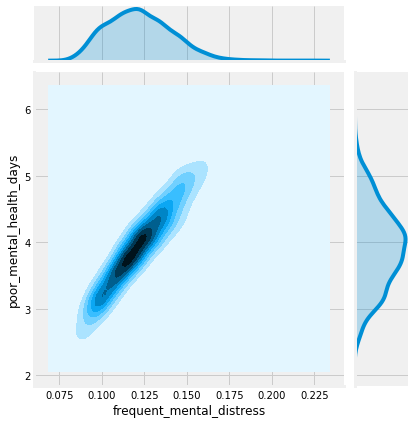

In [8]:
sns.jointplot("frequent_mental_distress", "poor_mental_health_days", data=df, kind='kde')
plt.show()

In [76]:
df.columns

Index(['FIPS_state', 'FIPS_county', 'FIPS_full', 'state', 'county', 'year',
       'YPLL', 'poor_health', 'poor_physical_health_days',
       'poor_mental_health_days', 'LBW', 'smokers', 'obese',
       'food_environment_index', 'physically_inactive', 'exercise_acces',
       'excessive_drinking', 'alcohol_impaired_driving_deaths',
       'chlamydia_rate', 'teen_birth_rate', 'uninsured', 'PCP', 'dentists',
       'MHP', 'preventable_hospital_stays', 'mammography_screenings',
       'flu_vaccinated', 'high_school_graduation', 'college', 'unemployment',
       'children_in_oiverty', 'income_inequality',
       'children_in_singleparent_household', 'social_associations',
       'violent_crime', 'injury_deaths', 'air_pollution', 'water_violation',
       'severe_housing_problems', 'driving_alone_work',
       'driving_alone_longcommute', 'life_expectancy',
       'premature_age_adjusted_mortality', 'frequent_physical_distress',
       'frequent_mental_distress', 'diabetes', 'food_insecurit

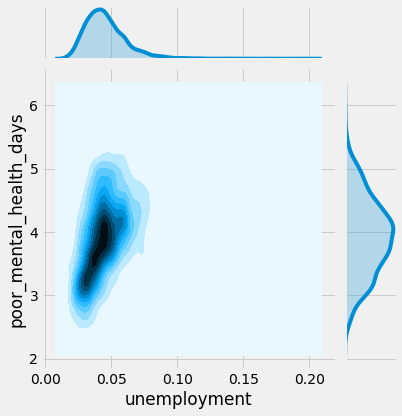

In [77]:
sns.jointplot("unemployment", "poor_mental_health_days", data=df, kind='kde')

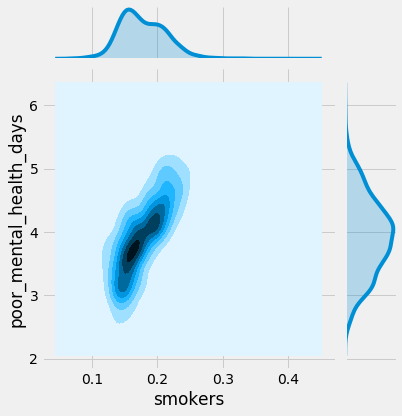

In [78]:
sns.jointplot("smokers", "poor_mental_health_days", data=df, kind='kde')

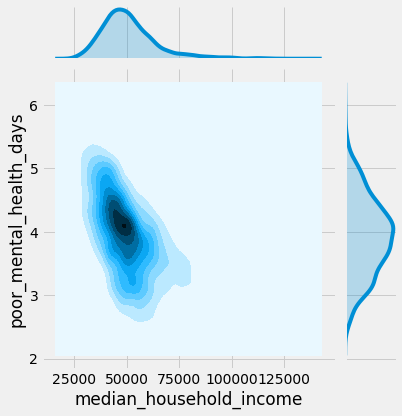

In [79]:
sns.jointplot("median_household_income", "poor_mental_health_days", data=df, kind='kde')

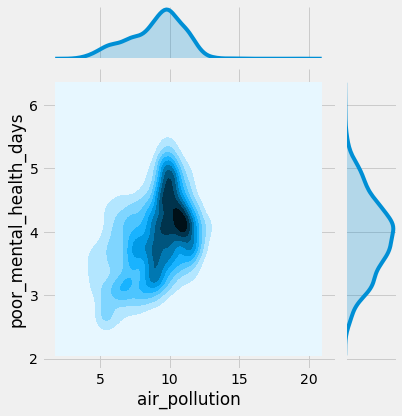

In [81]:
sns.jointplot("air_pollution", "poor_mental_health_days", data=df, kind='kde')

## Linear Regression

In [67]:
df = pd.read_csv('data_cleaned.csv')